In [2]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
import matplotlib.pyplot as plt
import numpy as np

import sys, os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', 'lib')))
from new_numba import *

In [3]:
@njit(cache=True)
def rg_step_fixed(J, a):
    D = len(J) - 1
    r_max = (D - 2) // 3

    J_new = np.empty_like(J)
    J_new[0] = 0.0

    # Head: exact renormalization
    for r in range(1, r_max + 1):
        log_R_pp, log_R_pm = log_Rpp_Rpm(r, J)
        J_new[r] = 0.5 * (log_R_pp - log_R_pm)

    # Tail: power-law continuation
    anchor = J_new[r_max]
    for r in range(r_max + 1, D + 1):
        J_new[r] = anchor * (r_max / r) ** a

    return J_new


def find_Jc(a, Jlow=0.1, Jhigh=12.0, max_distance=100, tol=1e-5,
            growth_threshold=1e6, decay_threshold=1e-6):
    if not (0 < a <= 2):
        raise ValueError("a must be in (0,2)")

    def grows(J0):
        J = build_J(J0, a, D=max_distance)
        J1_initial = abs(J[1])

        for _ in range(30):

            # early decision:
            if abs(J[1]) > growth_threshold:
                return True   # flows to ordered phase
            if abs(J[1]) < decay_threshold:
                return False  # flows to disordered phase

            # apply full RG step
            J = rg_step_fixed(J, a)

        # fallback: check increasing or decreasing tendency
        return abs(J[1]) > J1_initial

    # Bisection on J0: growth → ordered, decay → disordered
    while (Jhigh - Jlow) > tol:
        Jmid = 0.5 * (Jlow + Jhigh)
        if grows(Jmid):
            Jhigh = Jmid
        else:
            Jlow = Jmid

    return 0.5 * (Jlow + Jhigh)


@njit(cache=True)
def renormalized_field(J, H):
    """
    Renormalized magnetic field H' for two neighbouring 3-spin blocks,
    coupled by J and in external field H.
    """
    D = len(J) - 1

    # Intracell energies
    E_plus  = intracell_energies(plus_configs,  J)
    E_minus = intracell_energies(minus_configs, J)

    # Block indices in microscopic chain
    left_pos  = np.array([0, 1, 2], dtype=np.int64)
    right_pos = np.array([3, 4, 5], dtype=np.int64)

    # Distances between left/right spins
    distances = np.empty((3, 3), dtype=np.int64)
    for a_ in range(3):
        for b_ in range(3):
            distances[a_, b_] = abs(right_pos[b_] - left_pos[a_])

    n_plus  = plus_configs.shape[0]
    n_minus = minus_configs.shape[0]

    # -------- R(++): majority + on both blocks --------
    n_pp = n_plus * n_plus
    totals_pp = np.empty(n_pp, dtype=np.float64)
    idx = 0
    for iL in range(n_plus):
        sL = plus_configs[iL]
        EL = E_plus[iL]
        magL = sL[0] + sL[1] + sL[2]

        for iR in range(n_plus):
            sR = plus_configs[iR]
            ER = E_plus[iR]
            magR = sR[0] + sR[1] + sR[2]

            E_int = 0.0
            for a_ in range(3):
                for b_ in range(3):
                    d = distances[a_, b_]
                    if d <= D:
                        E_int += J[d] * sL[a_] * sR[b_]

            totals_pp[idx] = EL + ER + E_int + H * (magL + magR)
            idx += 1

    # -------- R(--): majority - on both blocks --------
    n_mm = n_minus * n_minus
    totals_mm = np.empty(n_mm, dtype=np.float64)
    idx = 0
    for iL in range(n_minus):
        sL = minus_configs[iL]
        EL = E_minus[iL]
        magL = sL[0] + sL[1] + sL[2]

        for iR in range(n_minus):
            sR = minus_configs[iR]
            ER = E_minus[iR]
            magR = sR[0] + sR[1] + sR[2]

            E_int = 0.0
            for a_ in range(3):
                for b_ in range(3):
                    d = distances[a_, b_]
                    if d <= D:
                        E_int += J[d] * sL[a_] * sR[b_]

            totals_mm[idx] = EL + ER + E_int + H * (magL + magR)
            idx += 1

    log_pp = logsumexp(totals_pp)
    log_mm = logsumexp(totals_mm)

    # 1/4 factor matches your earlier convention
    return 0.25 * (log_pp - log_mm)


@njit(cache=True)
def dH_dH(J, eps=1e-8):
    """
    Derivative dH'/dH at H=0, via finite difference.
    """
    H0  = renormalized_field(J, 0.0)
    H1  = renormalized_field(J, eps)

    if not np.isfinite(H0) or not np.isfinite(H1):
        return np.nan

    return (H1 - H0) / eps


# ============================================================
# 7. Magnetization via RG + field scaling
# ============================================================

def magnetization(J0, a, Jc, D,
                  n_steps=10,
                  eps=1e-8):
    """
    Magnetization at bare coupling J0 for given a and D,
    using fixed-length RG and dH'/dH.

    Convention:
      - For J0 <= Jc → M = 0 (disordered).
      - For J0 >  Jc → M > 0, with 'sink' magnetization set to 1.
    """
    # Disordered side
    if J0 <= Jc:
        return 0.0

    # Ordered sink magnetization (by convention)
    M_sink = 1.0

    # Spatial dimension & rescaling factor
    b = 3.0
    d = 1.0

    # Initial couplings
    J = build_J(J0, a, D)

    prod_R = 1.0
    k = 0

    for step in range(n_steps):
        dH = dH_dH(J, eps=eps)
        if not np.isfinite(dH) or dH <= 0.0:
            break

        prod_R *= dH
        k += 1

        J = rg_step_fixed(J, a)

    if k == 0:
        return 0.0

    scale = (b ** (-d)) ** k
    M0 = scale * prod_R * M_sink
    return float(M0)


# ============================================================
# 8. RG flow generation and plotting helpers
# ============================================================

def generate_rg_flow(J0, a, D, n_steps):
    """
    Generate full RG flow J^{(0)}, J^{(1)}, ..., J^{(n_steps)}.

    Each element is a vector of length D+1 (fixed).
    """
    J = build_J(J0, a, D)
    flow = [J.copy()]
    for _ in range(n_steps):
        J = rg_step_fixed(J, a)
        flow.append(J.copy())
    return flow


def plot_rg_flow(flow, distances_to_plot=None):
    """
    Plot RG flow of selected couplings J_r vs RG step.
    """
    n_steps_plus_1 = len(flow)
    D = len(flow[0]) - 1
    steps = np.arange(n_steps_plus_1)

    if distances_to_plot is None:
        distances_to_plot = [1, 2, 3, 4, 5]

    plt.figure(figsize=(7, 5))
    for r in distances_to_plot:
        if 1 <= r <= D:
            vals = np.array([J[r] for J in flow])
            plt.plot(steps, vals, marker='o', label=f"J_{r}")

    plt.xlabel("RG step")
    plt.ylabel("Coupling J_r")
    plt.title("Fixed-length RG flow of couplings")
    plt.grid(True, alpha=0.4)
    plt.legend()
    plt.tight_layout()
    plt.show()


def compute_Jc_over_a(a_values, max_distance, Jlow=1e-5, Jhigh=1e2, tol=1e-5):
    Jc_values = []
    for a in a_values:
        Jc = find_Jc(a, Jlow=1e-2, Jhigh=1e2, max_distance=max_distance,
                     tol=1e-5, growth_threshold=1e6, decay_threshold=1e-6)
        Jc_values.append(Jc)
    return np.array(Jc_values)


def plot_Tc_vs_a(a_values, Jc_values):
    Tc_values = 1.0 / Jc_values
    plt.figure(figsize=(7, 5))
    plt.plot(a_values, Tc_values, "-o", markersize=5)
    plt.xlabel("Interaction exponent a")
    plt.ylabel("Critical temperature Tc = 1/Jc")
    plt.title("Critical temperature Tc vs a (fixed-length RG)")
    plt.grid(True, alpha=0.4)
    plt.tight_layout()
    plt.show()

# RG flow

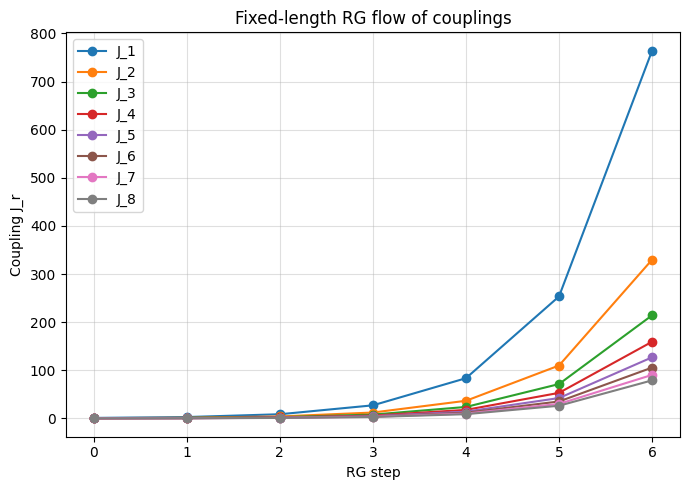

In [4]:
a = 1     # interaction exponent
D = 60      # max distance in couplings
n_steps = 6

J0 = 1.0    # initial nearest-neighbor coupling

flow = generate_rg_flow(J0, a, D, n_steps)
plot_rg_flow(flow, distances_to_plot=[1, 2, 3, 4, 5, 6, 7, 8])

# Critical temperature line

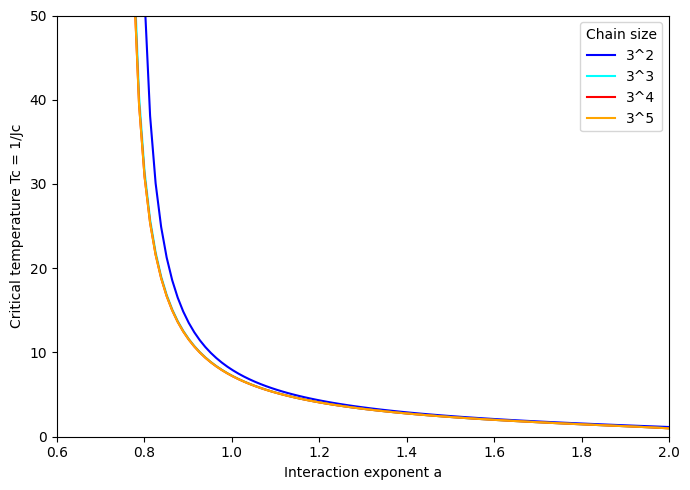

In [181]:
# Range of exponents
a_values = np.linspace(0.75, 2.0, 100)

plt.figure(figsize=(7, 5))
plt.plot(a_values, 1/compute_Jc_over_a(a_values, 3**2), c='b', label='3^2')
plt.plot(a_values, 1/compute_Jc_over_a(a_values, 3**3), c='cyan', label='3^3')
plt.plot(a_values, 1/compute_Jc_over_a(a_values, 3**4), c='r', label='3^4')
plt.plot(a_values, 1/compute_Jc_over_a(a_values, 3**5), c='orange', label='3^5')
plt.xlabel("Interaction exponent a")
plt.ylabel("Critical temperature Tc = 1/Jc")
plt.legend(title='Chain size')
plt.xlim(0.6, 2)
plt.ylim(0, 50)
plt.tight_layout()
plt.show()

# Magnetization

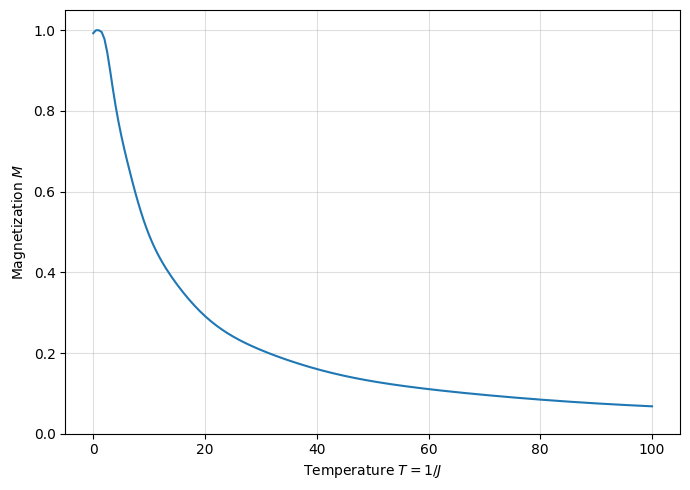

In [156]:
a = 1

if a < 0.8:
    Jc = 1e-10
    T_vals = np.linspace(0.01, 100, 200)
    J_vals = 1.0 / T_vals
else:
    Jc = find_Jc(a, Jlow=1e-2, Jhigh=1e2, max_distance=3**5, tol=1e-6, growth_threshold=1e6, decay_threshold=1e-6)
    T_vals = np.linspace(0.01, 1.5 / Jc, 200)
    J_vals = 1.0 / T_vals

M_vals = [
    magnetization(J0, a, Jc, D=3**5, n_steps=5)
    for J0 in J_vals]

plt.figure(figsize=(7, 5))
plt.plot(T_vals, M_vals, '-', markersize=3)
plt.xlabel(r"Temperature $T = 1/J$")
plt.ylabel(r"Magnetization $M$")
plt.ylim(0, None)
plt.ylim(0, 1.05)
plt.grid(True, alpha=0.4)
plt.tight_layout()
plt.show()

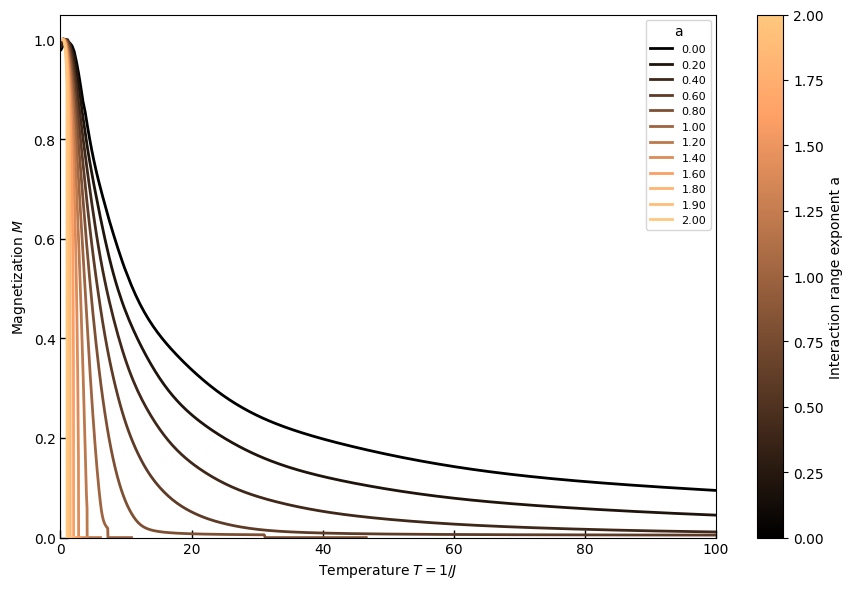

In [162]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

# =====================================================
# parameters
# =====================================================
D = 3**5                 # fixed chain max distance
n_steps_Jc = 7          # RG steps used in Jc search
n_steps_M  = 8          # RG steps used in magnetization
eps = 1e-8               # for dH/dH finite difference

a_values = np.array([0.0 , 0.2, 0.4, 0.6, 0.8,
                     1.0, 1.2, 1.4, 1.6, 1.8,
                     1.9, 2.0])

data_by_a = []

for a in a_values:
    if a < 0.8:
        Jc = 1e-12
        T_arr = np.linspace(0.1, 100, 300)
        J_arr = 1.0 / T_arr

    else:
        Jc = find_Jc(a,
                     Jlow=1e-2,
                     Jhigh=1e2,
                     max_distance=3**5,
                     tol=1e-6,
                     growth_threshold=1e6,
                     decay_threshold=1e-6)

        T_arr = np.linspace(0.10, 1.5 / Jc, 300)
        J_arr = 1.0 / T_arr

    # compute magnetization curve
    M_arr = np.array([
        magnetization(J0, a, Jc,
                      D=D,
                      n_steps=n_steps_M,
                      eps=eps)
        for J0 in J_arr
    ])

    data_by_a.append((T_arr, M_arr))


# PLOT
fig, ax = plt.subplots(figsize=(9, 6))

cmap = cm.copper
norm = plt.Normalize(a_values.min(), a_values.max())

for a, (T_arr, M_arr) in zip(a_values, data_by_a):
    ax.plot(T_arr, M_arr,
            color=cmap(norm(a)),
            linewidth=2,
            label=f"{a:.2f}")

# colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label('Interaction range exponent a')

ax.set_xlabel(r"Temperature $T = 1/J$")
ax.set_ylabel(r"Magnetization $M$")
ax.set_xlim(0, 100)
ax.set_ylim(0, 1.05)
ax.legend(title="a", fontsize=8, framealpha=0.8)
ax.tick_params(axis='both', direction='in', width=1, length=6)
plt.tight_layout()
plt.show()

# Energy densities

In [42]:
@njit(cache=True)
def G_r_prime(r, J):
    log_R_pp, log_R_pm = log_Rpp_Rpm(r, J)
    G_r = 0.5 * (log_R_pp + log_R_pm)
    return G_r


@njit(cache=True)
def G_prime(J):
    D = len(J) - 1
    r_max = (D - 2) // 3
    G_new = np.zeros(r_max + 1, dtype=np.float64)
    for r in range(1, r_max + 1):
        G_new[r] = G_r_prime(r, J)
    return G_new


def phi_from_G(J_init, a, max_steps=8):
    J = J_init.copy()
    phi = 0.0
    for k in range(max_steps):
        G_vec = G_prime(J)
        G_k = np.sum(G_vec[:])
        phi += (3**(-(k+1))) * G_k
        J = rg_step_fixed(J, a)
    return phi


def u_r(T, a, r_list, max_steps=8, D_fixed=3**8, dJ_rel=1e-3):
    J0 = 1.0 / T
    r_list = np.array(r_list, dtype=np.int64)

    J_base = build_J(J0, a, D_fixed)
    
    results = {}
    for r in r_list:
        J_r0 = J_base[r]
        dJ = dJ_rel * abs(J_r0) if J_r0 != 0 else dJ_rel

        Jp = J_base.copy()
        Jp[r] = J_r0 + dJ

        phi_p = phi_from_G(Jp, a, max_steps=max_steps)
        phi = phi_from_G(J_base, a, max_steps=max_steps)
        dphi_dJr = abs(phi_p - phi) / dJ
        results[r] = dphi_dJr / D_fixed
    return results

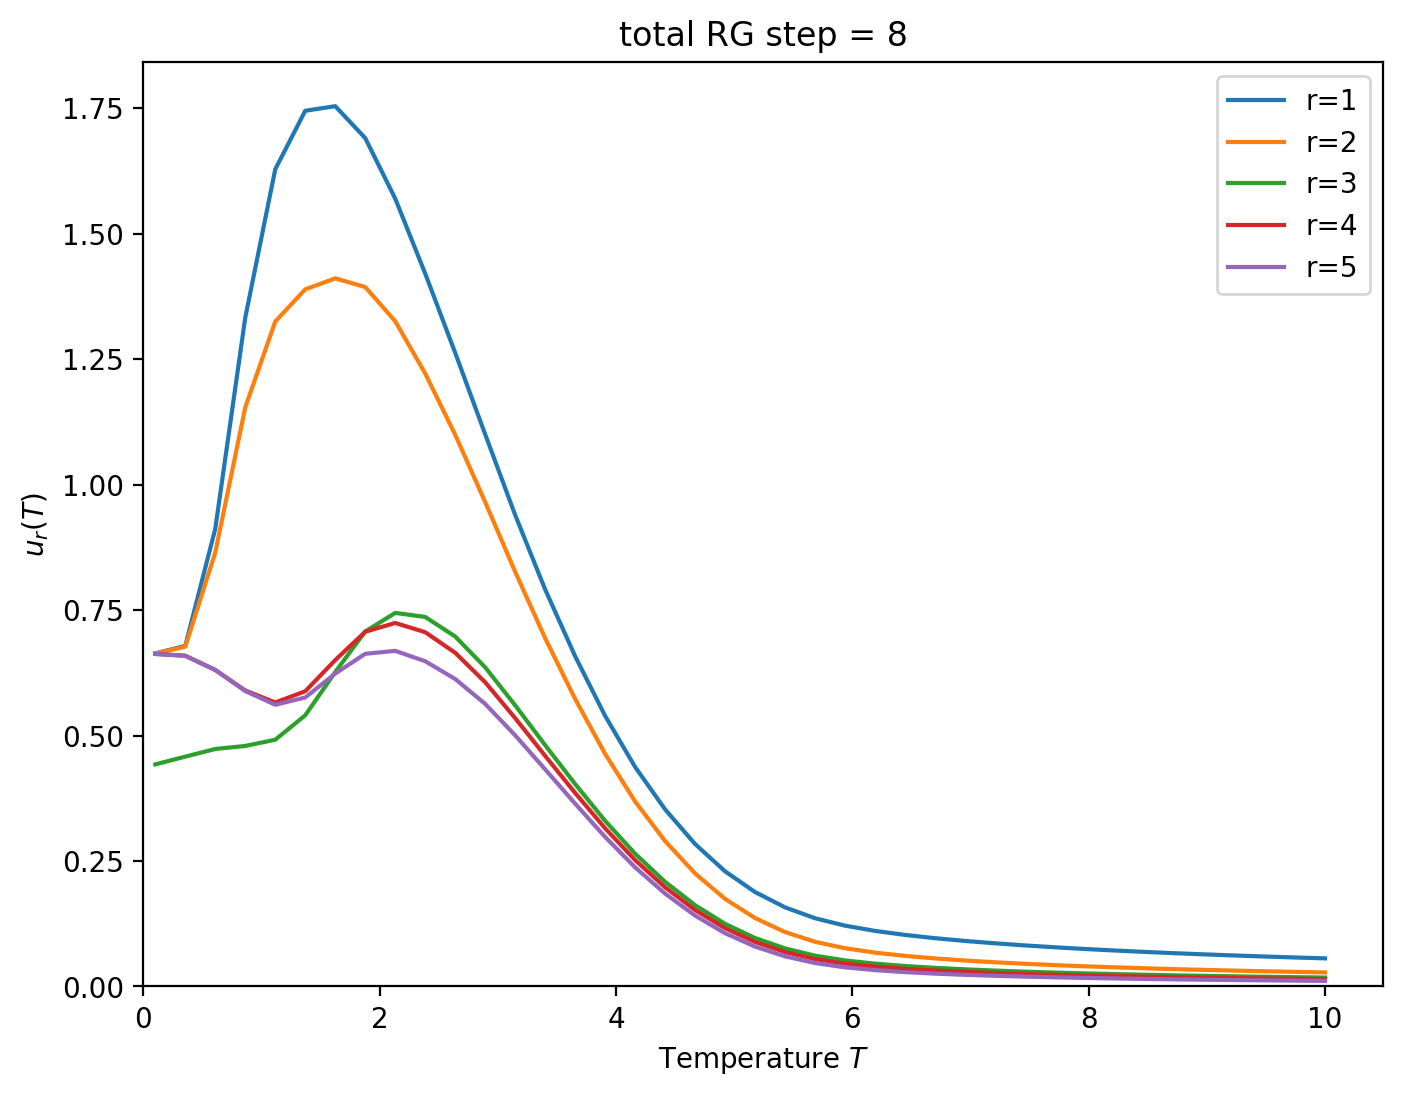

In [43]:
a = 1.
r_values = [1, 2, 3, 4, 5]
T_values = np.linspace(0.1, 10, 40)
u_results = {r: [] for r in r_values}

for T in T_values:
    ur_dict = u_r(T, a, r_values, max_steps=7, D_fixed=1000, dJ_rel=1e-3)
    for r in r_values:
        u_results[r].append(ur_dict[r])

plt.figure(figsize=(8, 6))
for r in r_values:
    plt.plot(T_values, u_results[r], label=f"r={r}")
plt.xlim(0, None)
plt.ylim(0, None)
plt.xlabel("Temperature $T$")
plt.ylabel("$u_r(T)$")
#plt.title("total RG step = 8")
plt.legend()
plt.show()

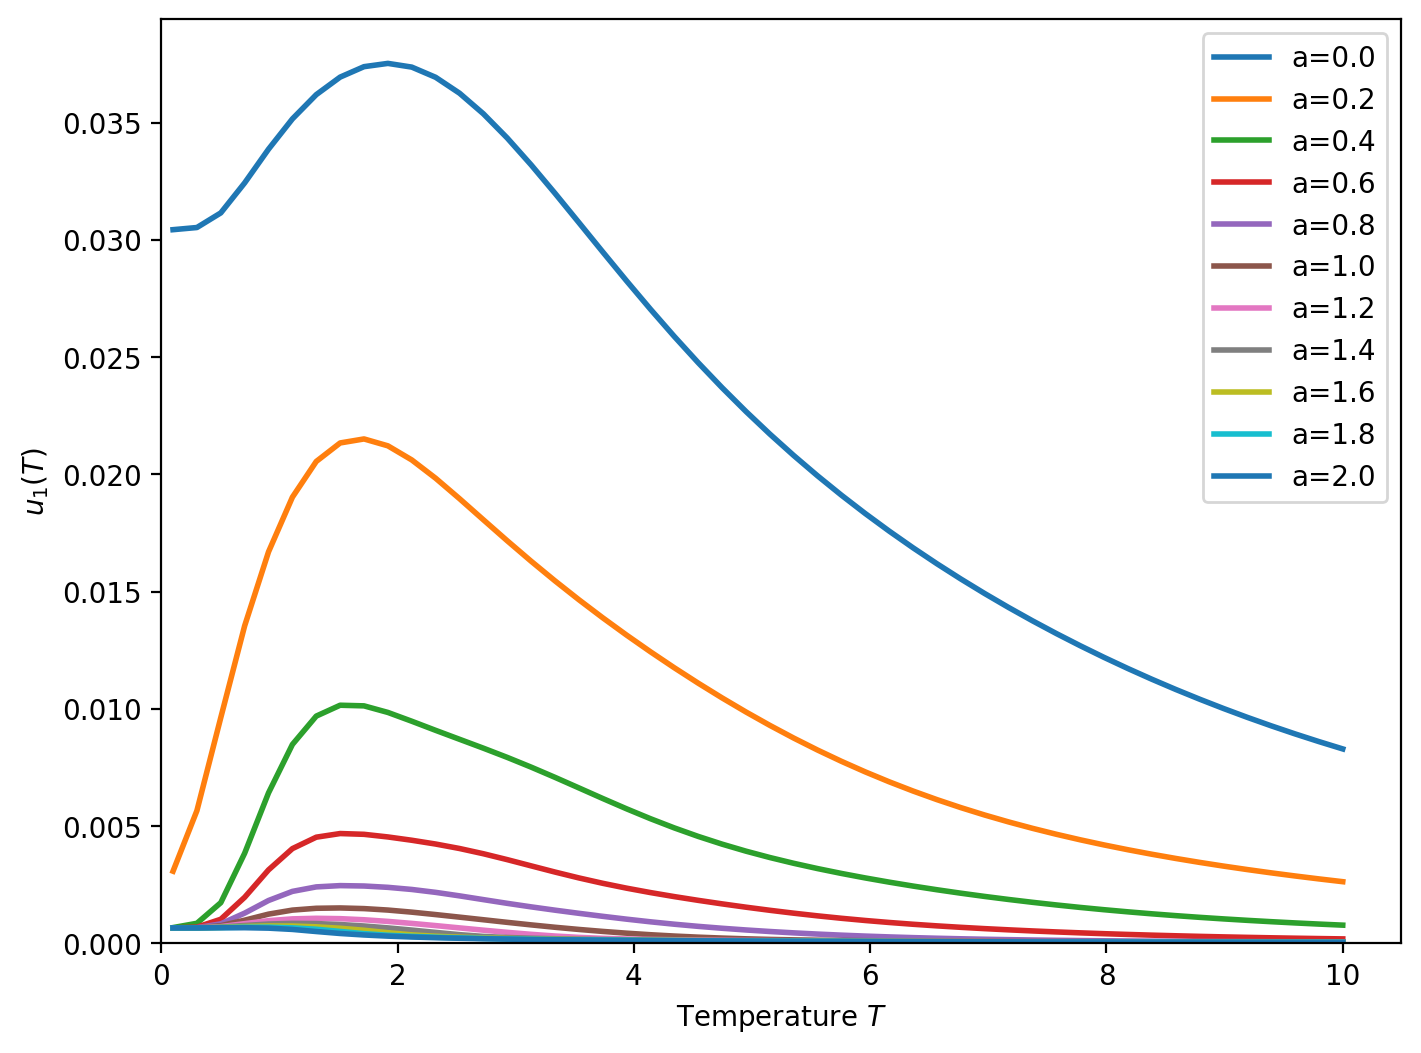

In [103]:
r_values = [1]
a_values = np.linspace(0, 2, 11)
T_values = np.linspace(0.1, 10, 50)

u_results = {a: {r: [] for r in r_values} for a in a_values}

for a in a_values:
    for T in T_values:
        ur_dict = u_r(T, a, r_values, max_steps=6, D_fixed=3**6, dJ_rel=1e-3)
        for r in r_values:
            u_results[a][r].append(ur_dict[r])

for r in r_values:
    plt.figure(figsize=(8, 6))
    for a in a_values:
        plt.plot(T_values, u_results[a][r], label=f"a={round(a,3)}", lw=2)
    plt.xlim(0, None)
    plt.ylim(0, None)
    plt.xlabel("Temperature $T$")
    plt.ylabel(f"$u_{r}(T)$")
    plt.legend()
    plt.show()

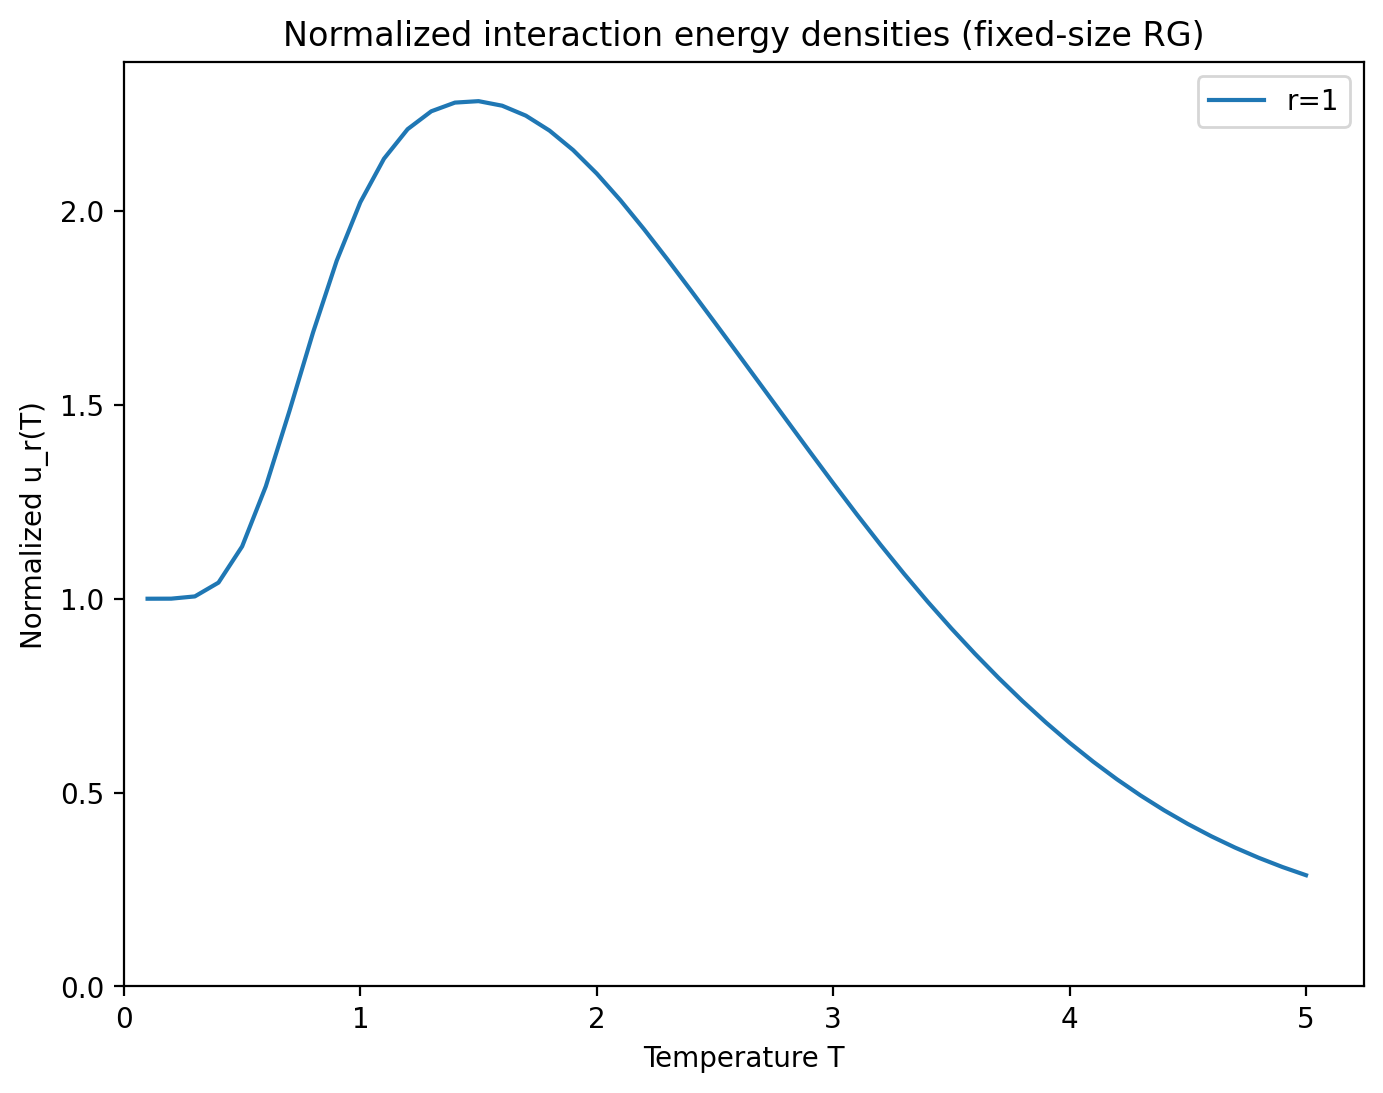

In [104]:
def u_r_curve_normalized(T_values, a, r_list, max_steps=8, D_fixed=None, dJ_rel=1e-3):
    """
    Compute normalized curves:
        u_r_norm(T) = u_r(T) / u_r(T_lowest)

    T_values must be sorted from **low to high**.
    """
    r_list = np.array(r_list, dtype=np.int64)

    raw_curves = {r: [] for r in r_list}

    # Compute raw u_r(T) values
    for T in T_values:
        ur_dict = u_r(
            T, a, r_list,
            max_steps=max_steps,
            D_fixed=D_fixed,
            dJ_rel=dJ_rel,
        )
        for r in r_list:
            raw_curves[r].append(ur_dict[r])

    # Normalize by first value
    norm_curves = {}
    for r in r_list:
        first_val = raw_curves[r][0]
        norm_curves[r] = np.array(raw_curves[r]) / first_val

    return norm_curves

r_values = [1, ]
a = 1.
T_values = np.linspace(0.1, 5, 50)   # low → high temperature

norm_curves = u_r_curve_normalized(T_values, a, r_values, max_steps=6, D_fixed=3**6)

plt.figure(figsize=(8,6))
for r in r_values:
    plt.plot(T_values, norm_curves[r], label=f"r={r}")

plt.xlim(0, None)
plt.ylim(0, None)
plt.xlabel("Temperature T")
plt.ylabel("Normalized u_r(T)")
plt.title("Normalized interaction energy densities (fixed-size RG)")
plt.legend()
plt.show()

In [86]:
r_values = [1]   # evaluate only r = 1
a_values = [0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.6, 1.8, 2.0]
T_values = np.linspace(0.1, 50, 300)  # low → high temperature

# Container
u_norm_results = {a: None for a in a_values}

# --- MAIN LOOP ---
for a in a_values:
    # get normalized curve for r=1
    curves_norm = u_r_curve_normalized(
        T_values,
        a,
        r_list=[1],          # only r=1
        max_steps=6,
        D_fixed=3**6,
        dJ_rel=1e-3
    )
    u_norm_results[a] = curves_norm[1]     # extract r=1 curve

/var/folders/56/k5k1hn6s4pd9x__t6s6fpclr0000gn/T/ipykernel_1218/382028563.py:49: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


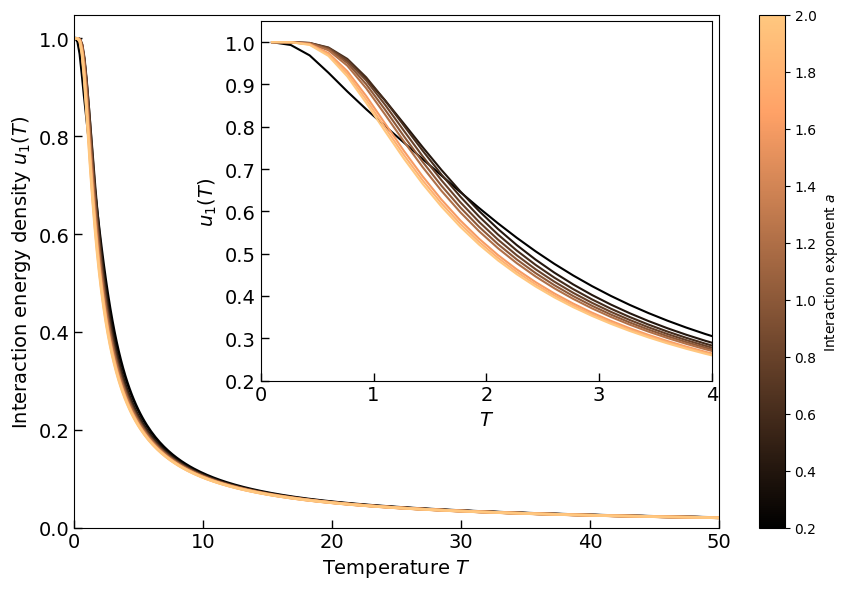

In [91]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

plt.figure(figsize=(9, 6))
ax = plt.gca()

# Colormap setup
cmap = cm.copper
a_min, a_max = min(a_values), max(a_values)
norm = plt.Normalize(a_min, a_max)

# Plot all curves with gradient colors
for a in a_values:
    color = cmap(norm(a))
    ax.plot(T_values, u_norm_results[a], color=color, lw=2,)

# Create ScalarMappable and colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

cbar = plt.colorbar(sm, ax=ax)
cbar.set_label("Interaction exponent $a$", rotation=90)

plt.xlim(0, 50)
plt.ylim(0, None)
ax.set_xlabel("Temperature $T$", fontsize=14)
ax.set_ylabel(r"Interaction energy density $u_1(T)$", fontsize=14)
ax.tick_params(axis='both', which='major', direction='in', labelsize=14, width=1, length=6)
# ------------------------------------------------------
# Inset axis (zoom)
# ------------------------------------------------------
inset = inset_axes(ax, width="70%", height="70%", loc="upper right")

for a in a_values:
    color = cmap(norm(a))
    inset.plot(
        T_values,
        u_norm_results[a],
        color=color,
        lw=1.5,
    )

# Zoomed x-range
inset.set_xlim(0, 4)
inset.set_ylim(0.2, None)
#inset.set_ylim(ax.get_ylim())
inset.tick_params(axis='both', which='major', direction='in', labelsize=14, width=1, length=6)
inset.set_xlabel("$T$", fontsize=14)
inset.set_ylabel(r"$u_1(T)$", fontsize=14)
plt.tight_layout()
plt.savefig("u1-T.png")
plt.show()

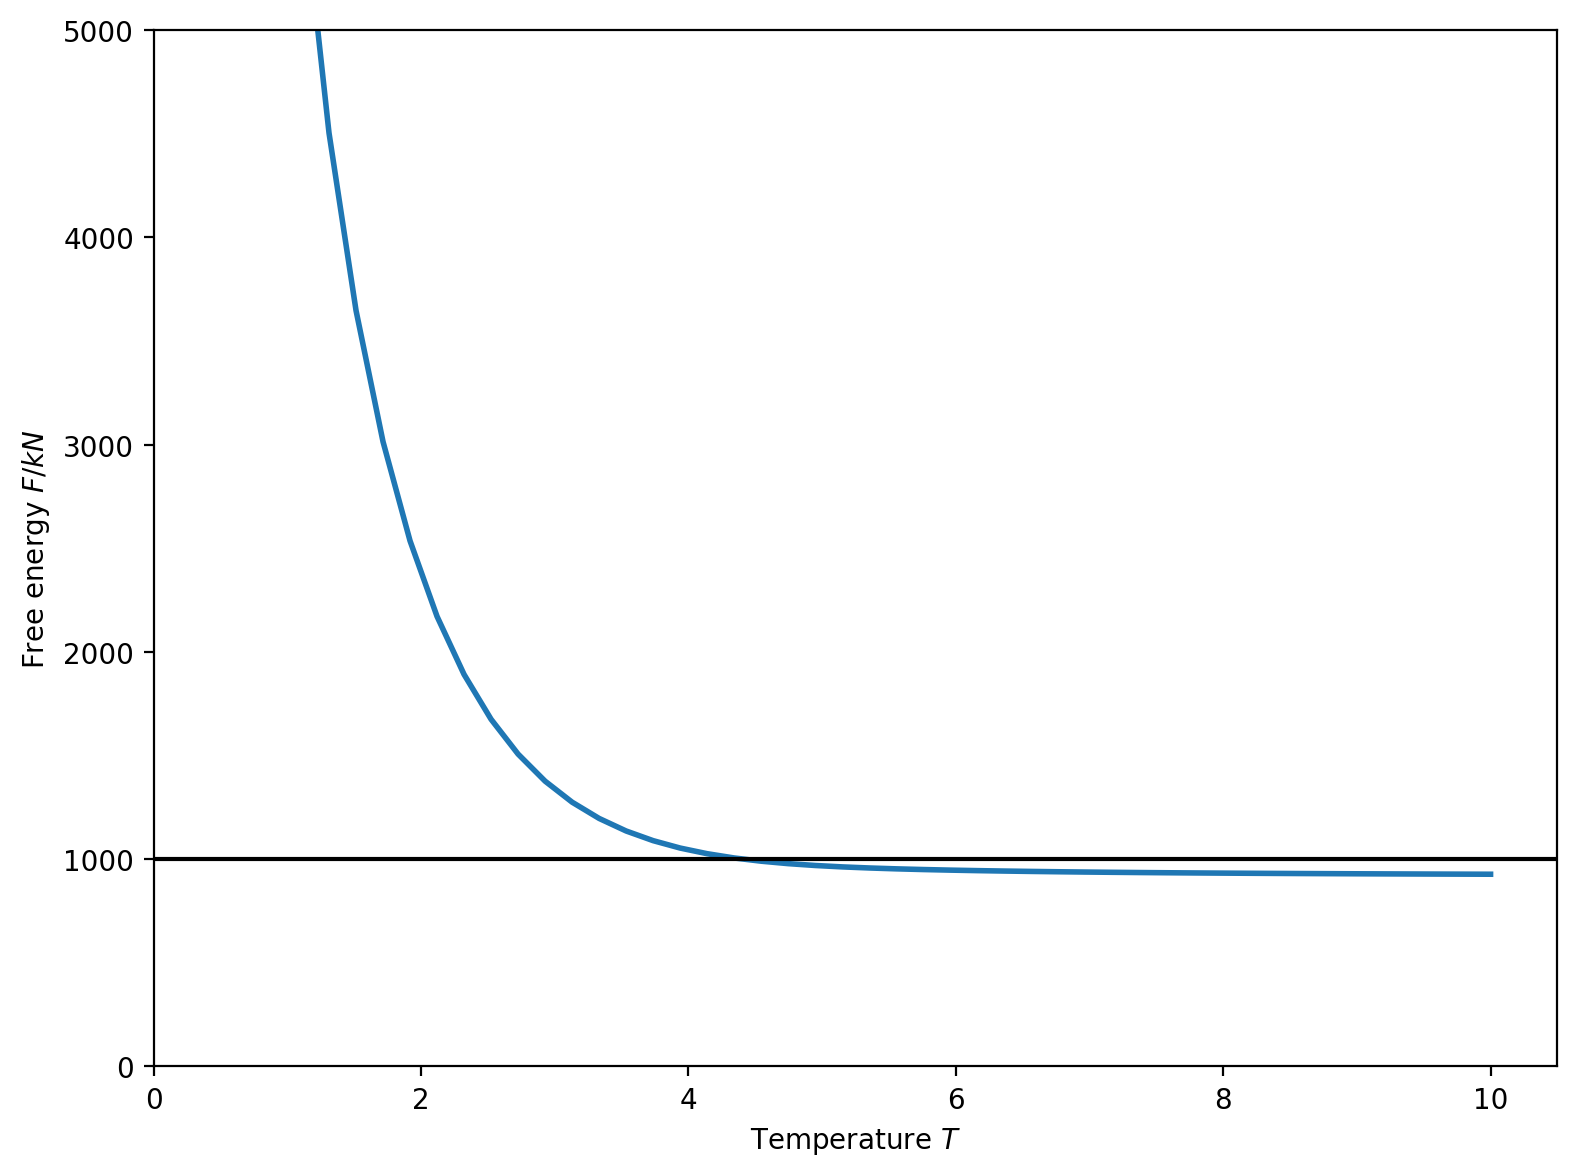

In [158]:
a = 1
T_values = np.linspace(0.1, 10, 50)

n_steps = 6
D0 = 1000

phi_values = []
for T in T_values:
    J_scale = 1.0 / T
    J0 = build_J(J_scale, a, D0)
    phi = phi_from_G(J0, a, n_steps)
    phi_values.append(phi)
phi_values = np.array(phi_values)

plt.figure(figsize=(8, 6))
plt.plot(T_values, phi_values, lw=2)
plt.xlim(0, None)
plt.ylim(0, 5000)
plt.axhline(y=1000, color='k')
plt.xlabel("Temperature $T$")
plt.ylabel(r"Free energy $F/kN$")
plt.tight_layout()
plt.show()